In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

In [20]:
df_train=pd.read_csv("Train Data.csv",delimiter=";")

In [21]:
df_train

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Balance_scaled,EstimatedSalary_scaled
0,0.636,0.202703,3,2,1,0,0,-0.883163,1.369486
1,0.554,0.202703,1,2,1,1,0,-0.883163,-1.254085
2,0.656,0.297297,10,2,1,0,0,-0.883163,1.437422
3,0.462,0.216216,2,1,1,1,0,1.486918,-0.557018
4,0.732,0.202703,5,2,1,1,0,-0.883163,-1.938770
...,...,...,...,...,...,...,...,...,...
165029,0.634,0.202703,2,1,1,1,0,-0.883163,0.382957
165030,0.884,0.229730,3,1,0,0,0,-0.883163,0.382951
165031,0.430,0.175676,5,1,1,1,0,-0.883163,0.295366
165032,0.408,0.162162,7,1,0,1,0,1.688303,-0.823217


# Train Test Split

In [3]:
x=df_train.drop(['Exited'], axis=1)
y=df_train['Exited']

In [4]:
# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Handling Class Imbalance

In [5]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [6]:
y_train.value_counts(),y_train_smote.value_counts()

(Exited
 0    104061
 1     27966
 Name: count, dtype: int64,
 Exited
 0    104061
 1    104061
 Name: count, dtype: int64)

# XGBoost

In [7]:
# Set up Hyperparameter tuning using GridSearchCV for XGBoost

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.8, 1.0]
    #'scale_pos_weight': [1, 3, 5],
    #'gamma': [0, 0.1, 0.5],
}


In [8]:
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss', tree_method='hist')

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', error_score='raise')

# Fit the model
grid_search.fit(x_train_smote, y_train_smote)

# Best estimator
best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [9]:
# Print classification report and confusion matrix for training set
y_train_pred = best_xgb.predict(x_train_smote)
print("Training Classification Report:")
print(classification_report(y_train_smote, y_train_pred))
print("Training Confusion Matrix:")
print(confusion_matrix(y_train_smote, y_train_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    104061
           1       0.93      0.86      0.89    104061

    accuracy                           0.90    208122
   macro avg       0.90      0.90      0.90    208122
weighted avg       0.90      0.90      0.90    208122

Training Confusion Matrix:
[[96897  7164]
 [14063 89998]]


In [10]:
# Print classification report for testing set
y_test_pred = best_xgb.predict(x_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     26052
           1       0.63      0.60      0.62      6955

    accuracy                           0.84     33007
   macro avg       0.76      0.75      0.76     33007
weighted avg       0.84      0.84      0.84     33007



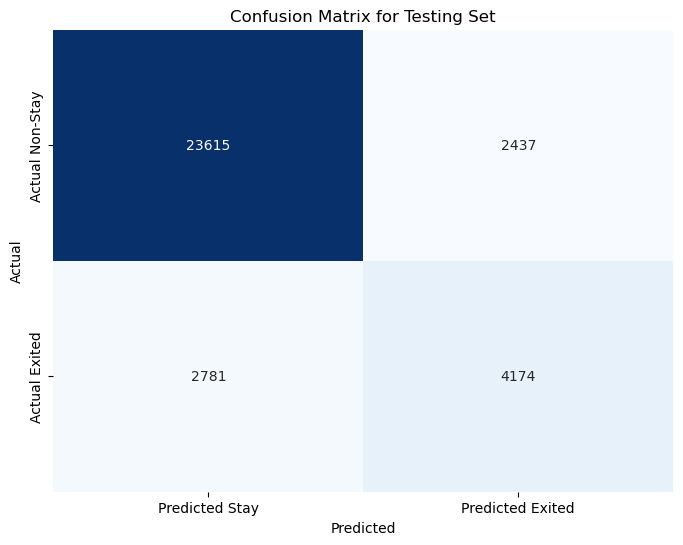

In [12]:
# Confusion matrix for testing set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
#print("Testing Confusion Matrix:")
#print(test_conf_matrix)

# Plot confusion matrix as a heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Stay', 'Predicted Exited'], yticklabels=['Actual Non-Stay', 'Actual Exited'])
plt.title('Confusion Matrix for Testing Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

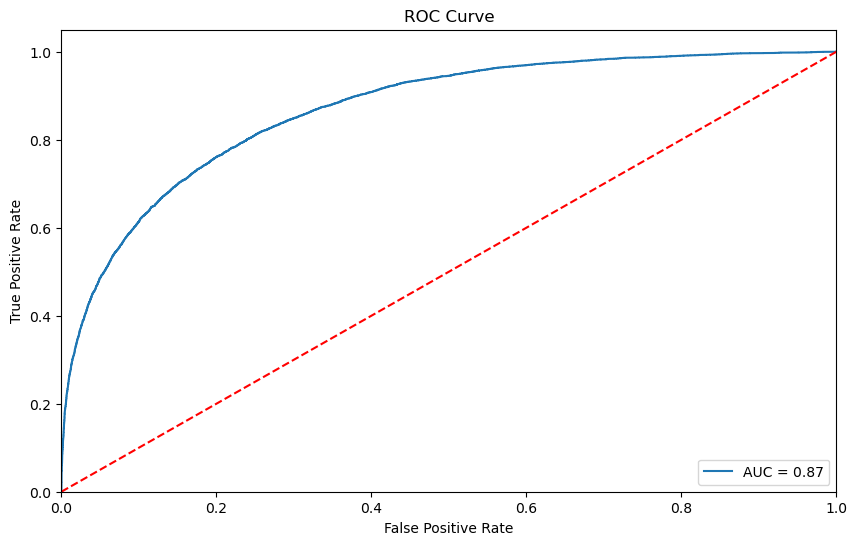

In [15]:
# ROC Curve for testing set
y_test_prob = best_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Save the model to a file
joblib.dump(best_xgb, 'churn_xgb_model.pkl')

['churn_xgb_model.pkl']